In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
class GaussianProcess:
    """A Gaussian Process class for creating and exploiting  
    a Gaussian Process model"""
    
    def __init__(self, n_restarts, optimizer):
        """Initialize a Gaussian Process model
        
        Input
        ------
        n_restarts: number of restarts of the local optimizer
        optimizer: algorithm of local optimization"""
        
        self.n_restarts = n_restarts
        self.optimizer = optimizer
        
    def Corr(self, X1, X2, theta):
        """Construct the correlation matrix between X1 and X2
        
        Input
        -----
        X1, X2: 2D arrays, (n_samples, n_features)
        theta: array, correlation legnths for different dimensions
        
        Output
        ------
        K: the correlation matrix
        """
        K = np.zeros((X1.shape[0],X2.shape[0]))
        for i in range(X1.shape[0]):
            K[i,:] = np.exp(-np.sum(theta*(X1[i,:]-X2)**2, axis=1))
            
        return K
    
    def Neglikelihood(self, theta):
        """Negative likelihood function
        
        Input
        -----
        theta: array, logarithm of the correlation legnths for different dimensions
        
        Output
        ------
        LnLike: likelihood value"""
        
        theta = 10**theta    # Correlation length
        n = self.X.shape[0]  # Number of training instances
        one = np.ones((n,1))      # Vector of ones
        
        # Construct correlation matrix
        K = self.Corr(self.X, self.X, theta) + np.eye(n)*1e-10
        inv_K = np.linalg.inv(K)   # Inverse of correlation matrix
        
        # Mean estimation
        mu = (one.T @ inv_K @ self.y)/ (one.T @ inv_K @ one)
        
        # Variance estimation
        SigmaSqr = (self.y-mu*one).T @ inv_K @ (self.y-mu*one) / n
        
        # Compute log-likelihood
        DetK = np.linalg.det(K)
        LnLike = -(n/2)*np.log(SigmaSqr) - 0.5*np.log(DetK)
        
        # Update attributes
        self.K, self.inv_K , self.mu, self.SigmaSqr = K, inv_K, mu, SigmaSqr
        
        return -LnLike.flatten()
    
    def fit(self, X, y):
        """GP model training
        
        Input
        -----
        X: 2D array of shape (n_samples, n_features)
        y: 2D array of shape (n_samples, 1)
        """
        
        self.X, self.y = X, y
        lb, ub = -3, 2
        
        # Generate random starting points (Latin Hypercube)
        lhd = lhs(self.X.shape[1], samples=self.n_restarts)
        
        # Scale random samples to the given bounds 
        initial_points = (ub-lb)*lhd + lb
        
        # Create A Bounds instance for optimization
        bnds = Bounds(lb*np.ones(X.shape[1]),ub*np.ones(X.shape[1]))
        
        # Run local optimizer on all points
        opt_para = np.zeros((self.n_restarts, self.X.shape[1]))
        opt_func = np.zeros((self.n_restarts, 1))
        for i in range(self.n_restarts):
            res = minimize(self.Neglikelihood, initial_points[i,:], method=self.optimizer,
                bounds=bnds)
            opt_para[i,:] = res.x
            opt_func[i,:] = res.fun
        
        # Locate the optimum results
        self.theta = opt_para[np.argmin(opt_func)]
        
        # Update attributes
        self.NegLnlike = self.Neglikelihood(self.theta)
  
    def predict(self, X_test):
        """GP model predicting
        
        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        
        Output
        ------
        f: GP predictions
        SSqr: Prediction variances"""
        
        n = self.X.shape[0]
        one = np.ones((n,1))
        
        # Construct correlation matrix between test and train data
        k = self.Corr(self.X, X_test, 10**self.theta)
        
        # Mean prediction
        f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)
        
        # Variance prediction
        SSqr = self.SigmaSqr*(1 - np.diag(k.T @ self.inv_K @ k))
        
        return f.flatten(), SSqr.flatten()
    def score(self, X_test, y_test):
        """Calculate root mean squared error
        
        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        y_test: test labels, array of shape (n_samples, )
        
        Output
        ------
        RMSE: the root mean square error"""
        
        y_pred, SSqr = self.predict(X_test)
        RMSE = np.sqrt(np.mean((y_pred-y_test)**2))
        
        return RMSE

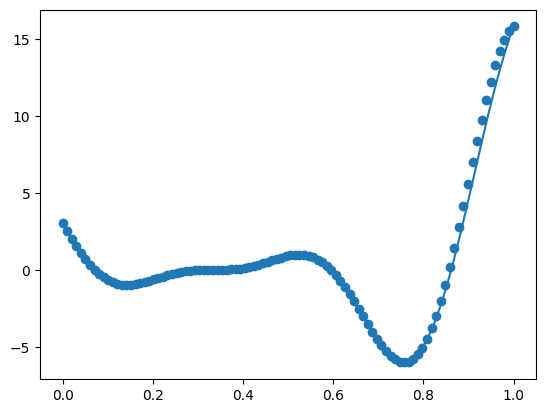

In [3]:
def Test_1D(X):
    """1D Test Function"""
    
    y = (X*6-2)**2*np.sin(X*12-4)
    
    return y

# Training data
X_train = np.array([0.0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1], ndmin=2).T
y_train = Test_1D(X_train)

# Testing data
X_test = np.linspace(0.0, 1, 100).reshape(-1,1)
y_test = Test_1D(X_test)

# GP model training
GP = GaussianProcess(n_restarts=10, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)

# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred)

In [15]:
X_train

array([[0. ],
       [0.1],
       [0.2],
       [0.4],
       [0.5],
       [0.6],
       [0.8],
       [1. ]])

C:\Users\ITA223.490INFRA6JQJ\AppData\Local\Temp\ipykernel_23164\1550571941.py:30: RuntimeWarning: overflow encountered in exp
  K[i,:] = np.exp(-np.sum(theta*(X1[i,:]-X2)**2, axis=1))
C:\research\wildlife\ee\pythonProject\lib\site-packages\numpy\linalg\linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


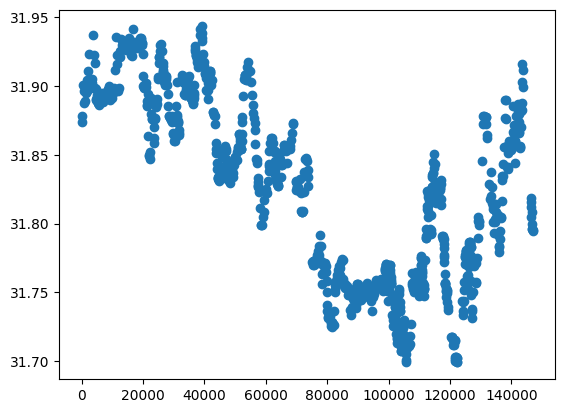

In [11]:
import pandas as pd

df = pd.read_csv ('gpr-test.csv')
df['date-obj']=pd.to_datetime(df['timestamp'])
#plt.plot(df['date-obj'], df['location-long'], label='Longitude')
first_date = df['date-obj'].iloc[0]
df["delta"] = df['date-obj']-first_date
df["delta"] = df["delta"].dt.total_seconds().div(60).astype(int)

df2 = df.iloc[0:2000:2]
test = df.loc[~df.index.isin(df2.index)][0:1000]

X_train = df2['delta'].to_numpy().reshape(-1,1)
y_train = df2['location-long'].to_numpy().reshape(-1, 1)

X_test  = test['delta'].to_numpy().reshape(-1,1)
y_test  = test['location-long'].to_numpy().reshape(-1,1)

# GP model training
GP = GaussianProcess(n_restarts=10, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)

# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred)

In [13]:
y_pred

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na